## **※ 런타임 유형을 GPU로 설정**

- **기계 독해**(**MRC**, Machine Reading Comprehension) :
    
    AI 알고리즘이 스스로 문서를 분석하고 질문에 대한 최상의 답을 찾아내는 것
    
- **KorQuAD 1.0** : LG CNS에서 공개한 한국어 기계독해 데이터셋

## 환경 준비

In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 19.0 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
!sudo apt-get install fonts-nanum -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,219 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126333 files and dire

In [4]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1b13f33cf52ff4f753496d5083090997e1ec9be3add738239530b442a672adfd
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## **1. KorQuAD 1.0 데이터 분석**

### 데이터 불러오기

In [5]:
import os
import pprint

from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud
from random import sample, seed
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

In [6]:
phoneme_tokenizer = Okt() # Konlpy의 한국어 형태소 분석기

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

DATA_IN_PATH = './data_in/KOR'
save_path = "bert_ckpt/"

if not os.path.exists(save_path):
    os.makedirs(save_path)
bert_tokenizer.save_pretrained(save_path)

tokenizer = BertWordPieceTokenizer("bert_ckpt/vocab.txt", lowercase=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

먼저 **KorQuAD 1.0 데이터셋**을 다운로드하자.

학습 데이터는 json 형식으로 구성되어 있기 떄문에 파일을 불러올 때 json.load 함수를 이용해 데이터를 train_data에 할당한다.

In [7]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

38527475/38527475 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
3881058/3881058 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

In [9]:
pprint.pprint(train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

### 지문 텍스트(context) 길이 분석

본격적으로 KorQuAD 데이터를 분석해 보자.

먼저 **지문 텍스트**를 **분석**하자.

In [10]:
documents = []
for d in train_data['data']:
    documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트 수: {}'.format(len(documents)))

전체 텍스트 수: 9681


총 지문 텍스트의 수는 9,700개 정도로 상당히 많은 지문이 들어 있음을 확인할 수 있다.

이제 이 데이터로 **지문 텍스트에 대한 길이를 분석**하자.

지문 텍스트 길이 분석은 **띄어쓰기 단위** 및 **버트 토크나이저**로 처리한 토큰 단위라는 두 방식으로 진행할 것이다.

**(1) 띄어쓰기 단위에 대한 길이 분석**

띄어 쓰기 토크나이징은 텍스트를 스페이스 단위로 구분하면 되기 때문에 split 함수를 활용해 띄어쓰기 토큰으로 만든다.

In [11]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))

print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


<ipython-input-12-41aafa7a509d>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([len_docs],


{'whiskers': [<matplotlib.lines.Line2D at 0x7c0f82f64b10>,
 'caps': [<matplotlib.lines.Line2D at 0x7c0f82f75e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c0f82f67f90>],
 'medians': [<matplotlib.lines.Line2D at 0x7c0f82f77190>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c0f82f84450>],
 'means': [<matplotlib.lines.Line2D at 0x7c0f82f77bd0>]}

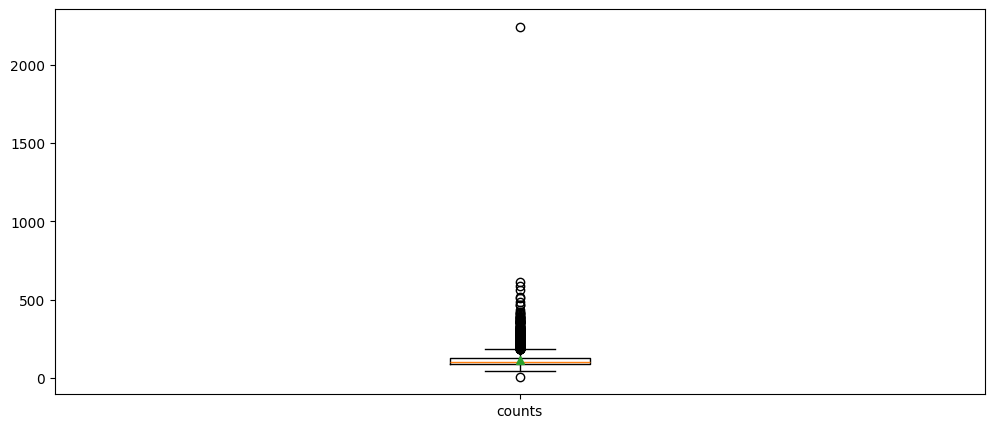

In [12]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

텍스트의 길이가 10에서 300 사이에 분포하는 모습인데, 텍스트의 길이가 2000이 넘는 케이스는 소수의 케이스로 이상치로 봐야할 것으로 보인다.

<ipython-input-13-0116e95de937>:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered_len_docs,


{'whiskers': [<matplotlib.lines.Line2D at 0x7c0f80e4c0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7c0f80e4d390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c0f80e43810>],
 'medians': [<matplotlib.lines.Line2D at 0x7c0f80e4d310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c0f80e4fa50>],
 'means': [<matplotlib.lines.Line2D at 0x7c0f80e4f150>]}

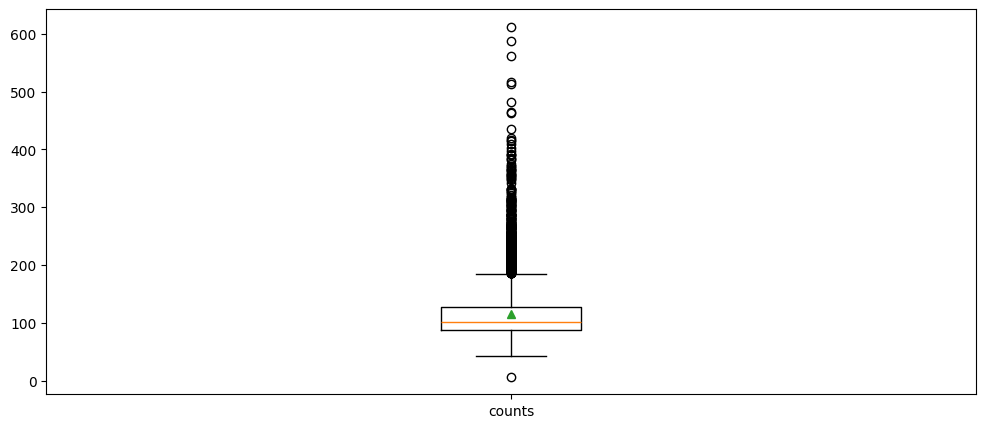

In [13]:
filtered_len_docs = [l for l in len_docs if l < 2000]

plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

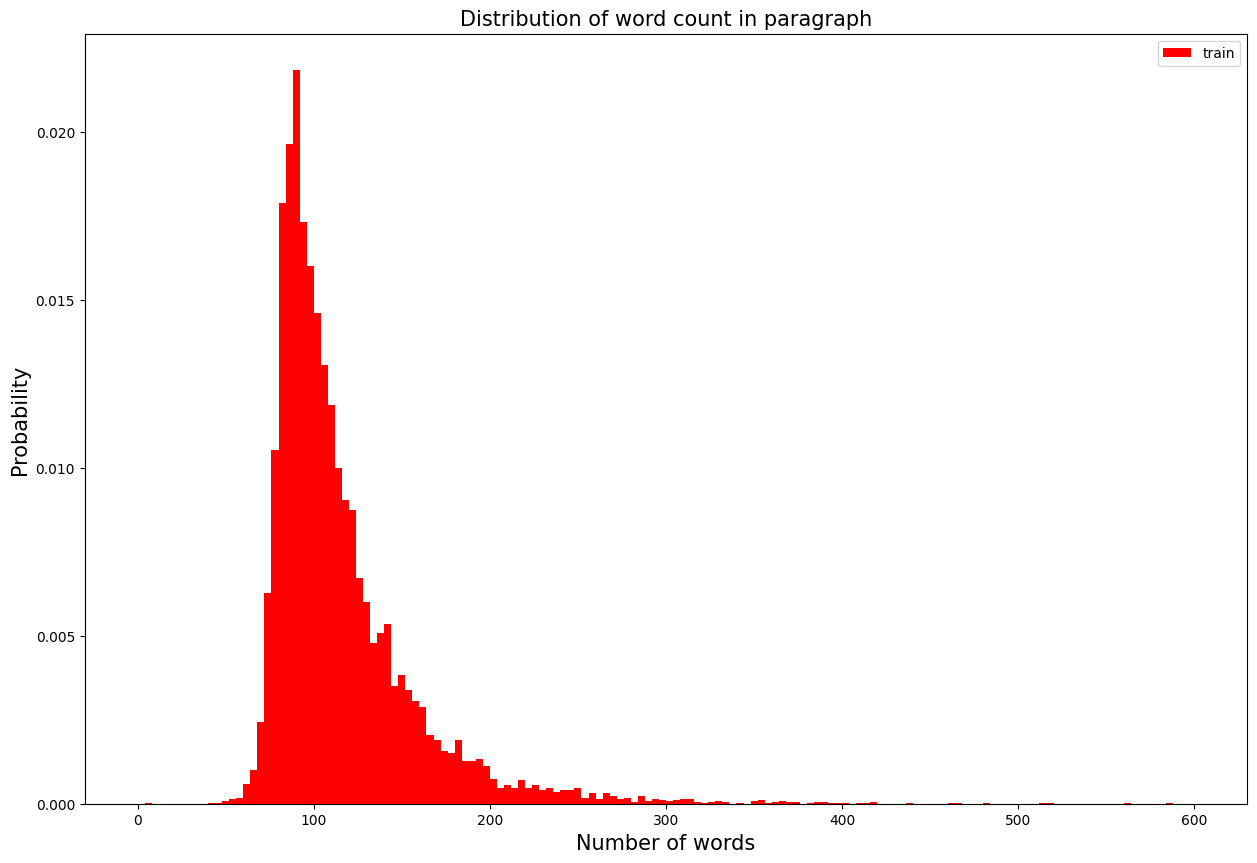

In [14]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

토큰 길이가 2000 미만인 길이 데이터에 대한 박스 플롯과 위의 그래프를 보면

**분포가 왼쪽으로 치우쳐**져 있는 것을 확인할 수 있다.

그리고 길이가 150을 지나는 지점부터는 많은 비중을 차지하지 않는 것으로 보인다.


실제로 모델에 입력하는 텍스트는 Bert Tokenizer를 활용해 처리된 토큰이기 때문에

위의 분석한 내용을 활용해 모델의 입력 텍스트 길이를 결정하기 어렵다.

**(2) 지문 텍스트 버트 토크나이저 토큰 길이 분석**

이제 지문 텍스트에 대해 **Bert Tokenizer로 처리한 토큰 길이**를 분석해 보자.

In [15]:
len_bert_tokenized_docs = []
for d in documents:
    token_ids = bert_tokenizer.encode(d, add_special_tokens=False)
    len_bert_tokenized_docs.append(len(token_ids))

print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


텍스트 최대 길이: 6367
텍스트 최소 길이: 120
텍스트 평균 길이: 311.88
텍스트 길이 표준편차: 129.44
텍스트 중간 길이: 279.0
제 1 사분위 텍스트 길이: 239.0
제 3 사분위 텍스트 길이: 344.0


띄어쓰기 단위 토큰 길이보다 늘어난 것을 확인할 수 있다.

평균 길이는 약 312 정도이고 중간 길이 120 정도이며, 표준 편차도 129로 커졌다.

Bert Tokenizer로 토큰을 나누면 한 띄어쓰기 토큰에 대해 다시 분리되기 때문이다.

이상치인 6000 미만의 길이 데이터만 활용해 박스 플롯을 그려보자.

<ipython-input-16-fe32947a1328>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(filtered_len_bert_tokenized_docs,


{'whiskers': [<matplotlib.lines.Line2D at 0x7c0f80b97a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7c0f80bb0bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c0f80b97190>],
 'medians': [<matplotlib.lines.Line2D at 0x7c0f80bb1f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c0f80bb31d0>],
 'means': [<matplotlib.lines.Line2D at 0x7c0f80bb2910>]}

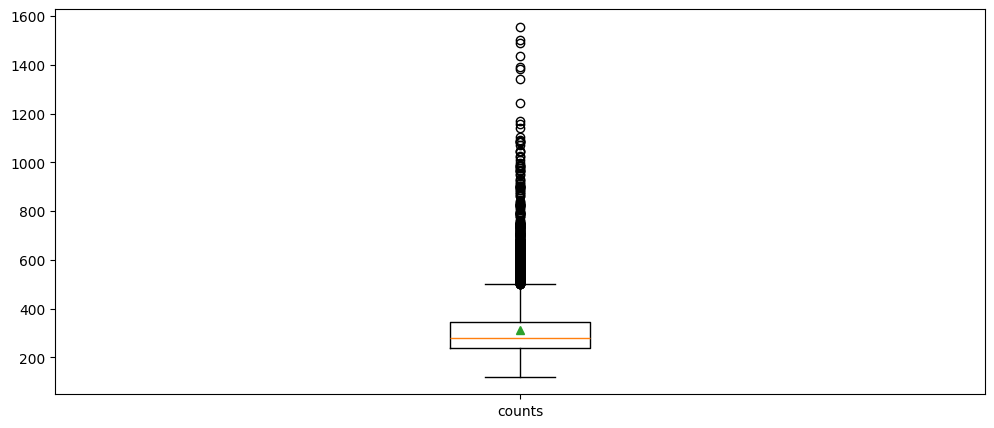

In [16]:
filtered_len_bert_tokenized_docs = [l for l in len_bert_tokenized_docs if l < 6000]

plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_bert_tokenized_docs,
             labels=['counts'],
             showmeans=True)

y축 스케일이 띄어쓰기 길이에서 분석한 박스 플롯보다 더 넓게 구성된 것을 확인할 수 있다.

주로 분포된 영역은 500에서 1200 사이 지만 1400 이상인 경우도 어느 정도 있어 보인다.

Text(0, 0.5, 'Probability')

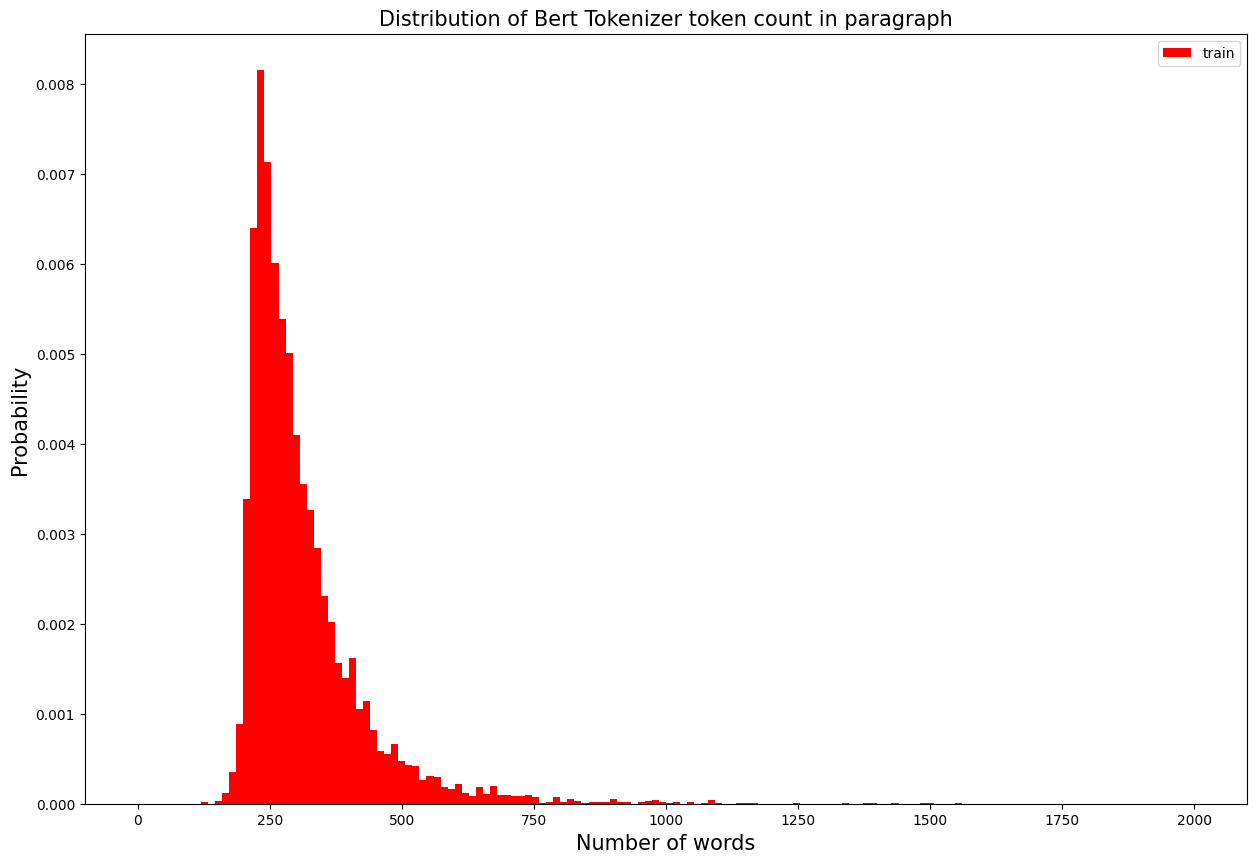

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_bert_tokenized_docs, bins=150, range=[0,2000], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 지문 텍스트 어휘 빈도 분석

이제 지문 텍스트 길이 분포를 살펴봤으니 **어휘 빈도**에 대해 분석해 보자.

빈도 분석은 기계독해 모델이 어떤 지식을 학습했는지 살펴보고 어떤 질문에 대해서 잘 응답할 수 있는지를 유추해 볼 수 있는 방법이다.

**(1) 어절(띄어쓰기) 토큰 기준**

In [18]:
sentences = []
for d in documents:
    sentences += sent_tokenize(d)

print('전체 문장 수: {}'.format(len(sentences)))

전체 문장 수: 67892


(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

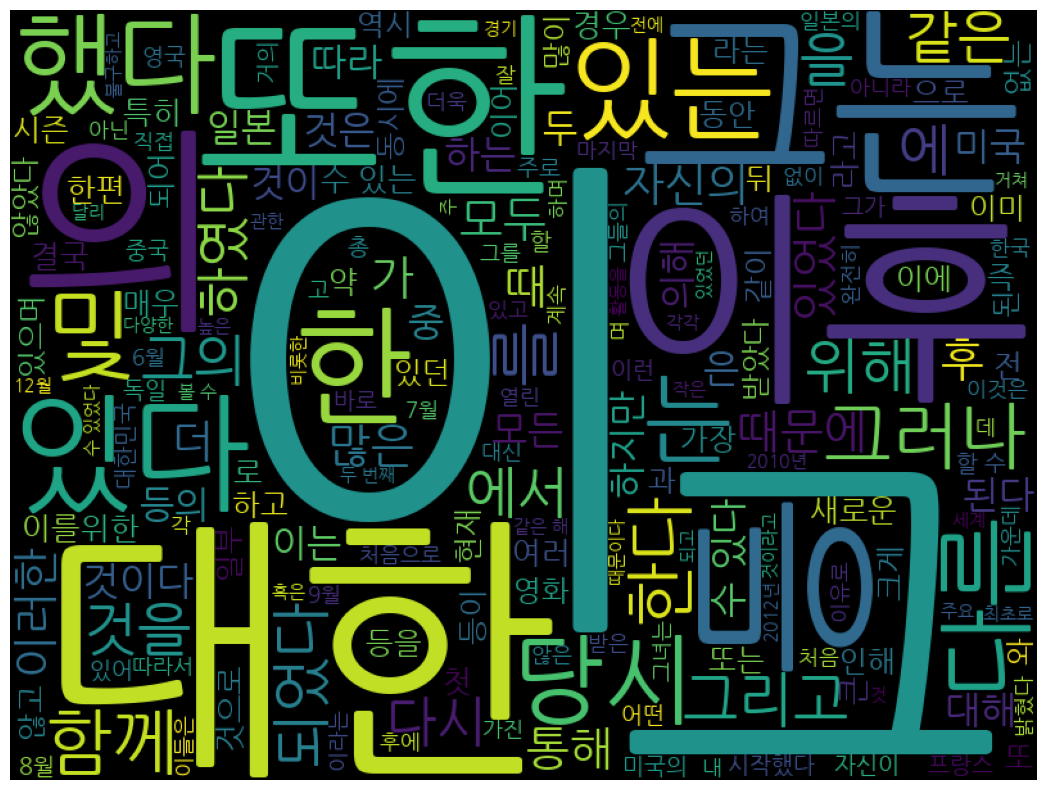

In [19]:
# 문장 텍스트 20000개 샘플링 (전체 데이터의 1/3)
sampled_docs = sample(sentences, 20000)

font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

샘플링한 지문 텍스트를 워드 클라우드로 분석한 결과이다.

KorQuAD 데이터셋이 위키피디아와 같은 지식 데이터를 기반으로 하다보니 이와 같은 띄어쓰기 토큰이 많이 나온 것으로 보인다.

띄어쓰기 토큰에 대한 분석에서는 지식 데이터가 어느 정보를 많이 가지고 있는지 확인하기 쉽지 않아 보인다.

**(2) 명사 토큰 기준**

명사로 분석하면 좀 더 명확하게 지식 데이터에 어떤 정보가 잇는지 알 수 있을 것이다.

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

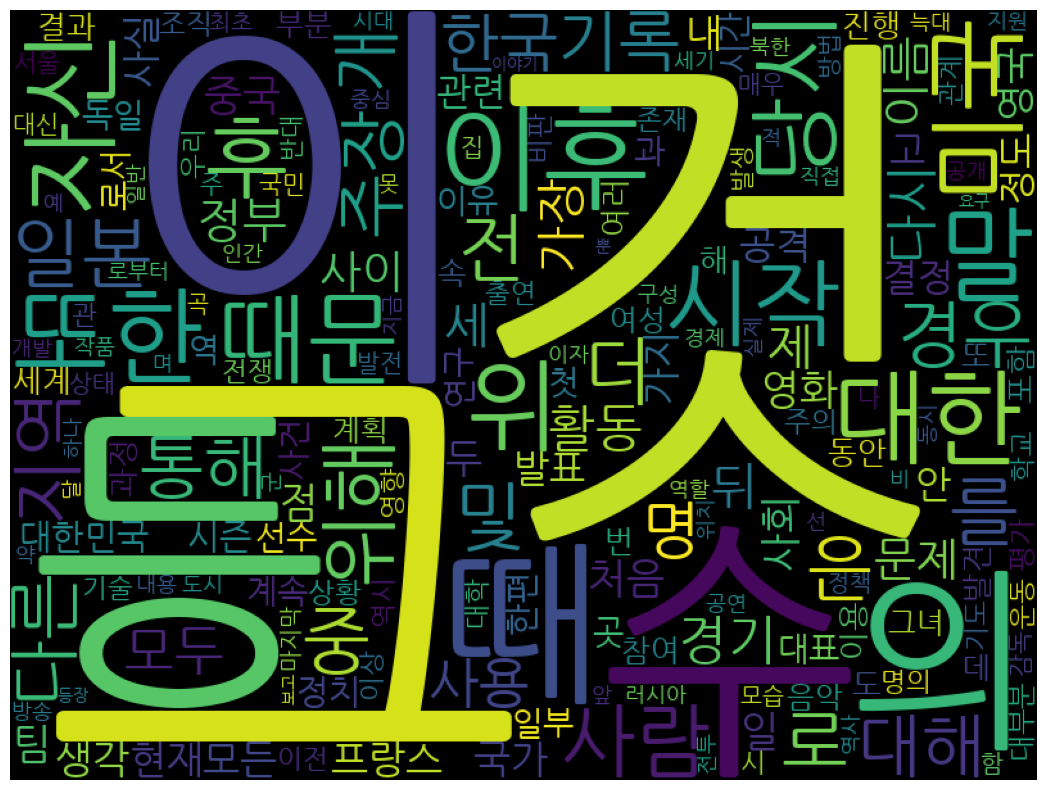

In [20]:
noun_extracted_docs = []
for d in sampled_docs:
    noun_extracted_docs += phoneme_tokenizer.nouns(d)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

형태소 분석으로 구한 명사에 대한 어휘 분석 결과이다.

‘일본’, ‘대한’과 같은 국적에 대한 단어가 보이고,

‘사람’, ‘사실’, ‘활동’, ‘정부’, ‘문제’, ‘기록’과 같은 큰 주제 또는 주제에 속하는 명사 단어가 다수 보이다.

여기서 정치나 문화, 인물과 같은 분야에 관한 내용이 많다는 것을 확인할 수 있다.

### 질문 텍스트(question) 길이 분석

KorQuAD 데이터셋에 ‘question’에 저장된 텍스트를 추출하기 위해서는

‘paragraphs’ 안에 있는 ‘qas’ 매열의 데이터에 접근해야 한다.

‘qas’ 정보를 먼저 추출하고 ‘qas’의 배열 정보에서 ‘question’ 텍스트 데이터만 저장해야 한다.

In [21]:
questions = []
for d in train_data['data']:
    qas = [p['qas'] for p in d['paragraphs']]
    for c in qas:
        questions += [q['question'] for q in c]

print('전체 질문 수: {}'.format(len(questions)))

전체 질문 수: 60407


총 질문 텍스트 수(60000)를 확인해 보면 지문 텍스트 수(9000)를 고려할 때

지문 당 약 6개의 질문이 있으리라 예상할 수 있다.

**(1) 질문 텍스트 어절(띄어쓰기) 토큰 길이 분석**

In [22]:
len_qs= []
for q in questions:
    len_qs.append(len(q.split())) # split 함수로 띄어쓰기 토큰 분리

print('텍스트 최대 길이: {}'.format(np.max(len_qs)))
print('텍스트 최소 길이: {}'.format(np.min(len_qs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_qs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_qs)))
print('텍스트 중간 길이: {}'.format(np.median(len_qs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 75)))

텍스트 최대 길이: 35
텍스트 최소 길이: 1
텍스트 평균 길이: 7.85
텍스트 길이 표준편차: 3.09
텍스트 중간 길이: 7.0
제 3 사분위 텍스트 길이: 10.0


띄어쓰기 토큰 길이로는 평균 8, 중간길이 7 정도이며,

제3사분위의 길이가 10이고 최대 길이가 35이다.

지문 텍스트 보다 질문 텍스트 길이 분포가 균등한 편인 것을 확인할 수 있다.

<ipython-input-23-26a73913404b>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([len_qs],


{'whiskers': [<matplotlib.lines.Line2D at 0x7c0f8073d150>,
 'caps': [<matplotlib.lines.Line2D at 0x7c0f764cc350>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c0f764c6510>],
 'medians': [<matplotlib.lines.Line2D at 0x7c0f764cf5d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c0f764cc850>],
 'means': [<matplotlib.lines.Line2D at 0x7c0f764cd1d0>]}

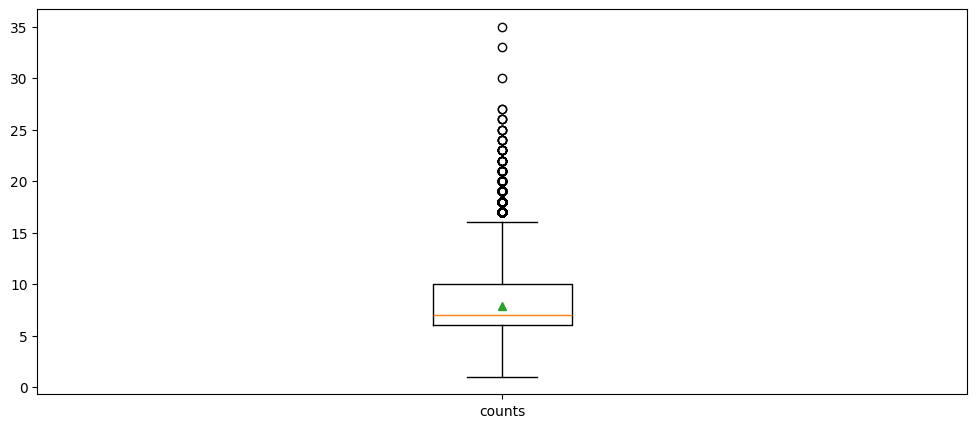

In [23]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_qs],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

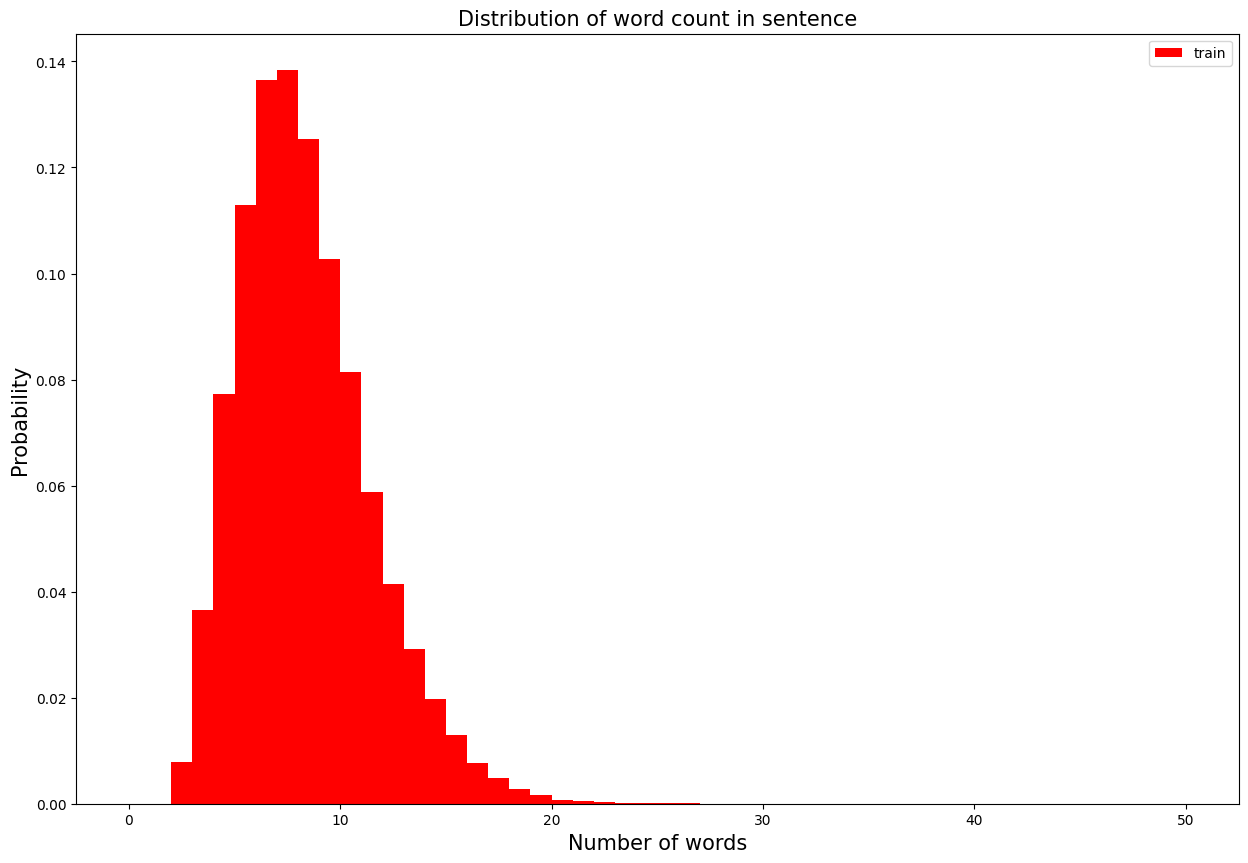

In [24]:
plt.figure(figsize=(15, 10))
plt.hist(len_qs, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

**(2) 질문 텍스트 버트 토크나이저 토큰 길이 분석**

In [25]:
len_bert_tokenized_q = []
for q in questions:
    token_ids = bert_tokenizer.encode(q, add_special_tokens=False)
    len_bert_tokenized_q.append(len(token_ids))

print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_q)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_q)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_q)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_q)))
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 75)))

텍스트 최대 길이: 91
텍스트 최소 길이: 4
텍스트 평균 길이: 22.07
텍스트 길이 표준편차: 7.96
텍스트 중간 길이: 21.0
제 1 사분위 텍스트 길이: 16.0
제 3 사분위 텍스트 길이: 27.0


<ipython-input-26-23714dcb67ae>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([len_bert_tokenized_q],


{'whiskers': [<matplotlib.lines.Line2D at 0x7c0f808d7390>,
 'caps': [<matplotlib.lines.Line2D at 0x7c0f808cc0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c0f808d6850>],
 'medians': [<matplotlib.lines.Line2D at 0x7c0f808cd950>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c0f808cf810>],
 'means': [<matplotlib.lines.Line2D at 0x7c0f808cefd0>]}

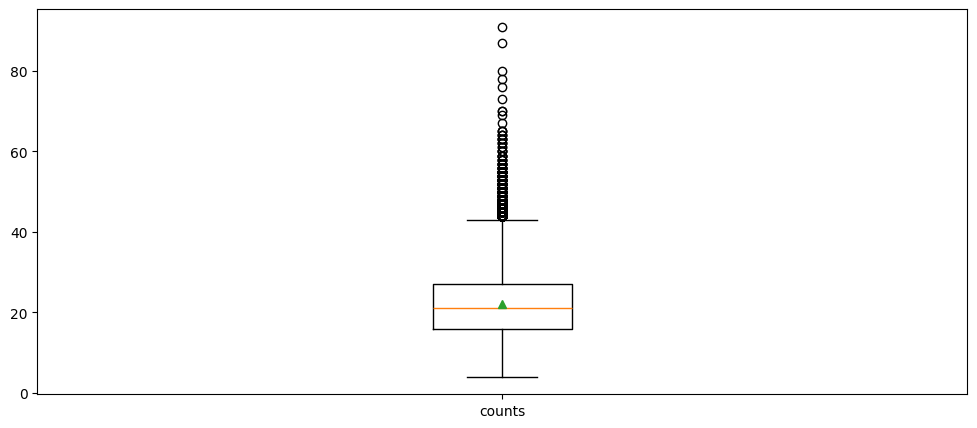

In [26]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_bert_tokenized_q],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

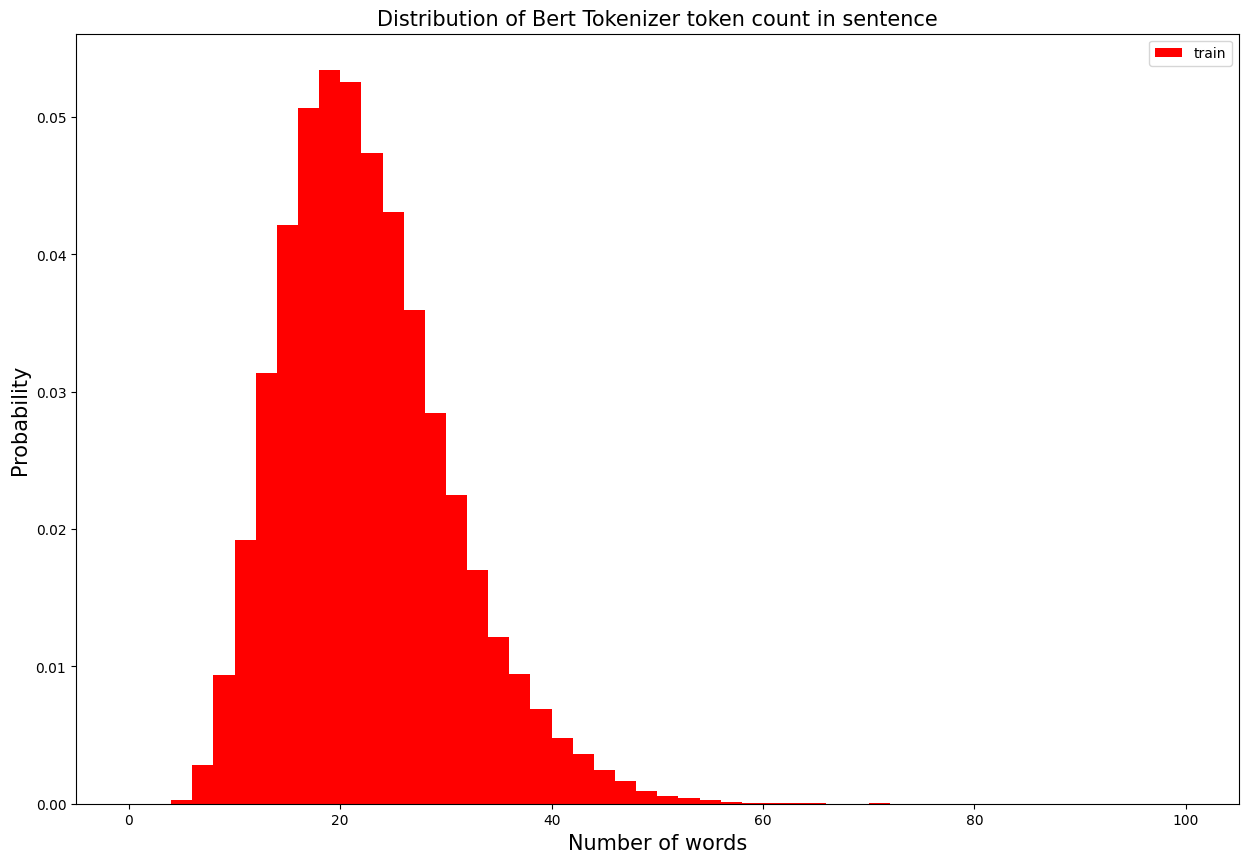

In [27]:
plt.figure(figsize=(15, 10))
plt.hist(len_bert_tokenized_q, bins=50, range=[0,100], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 질문 텍스트(question) 어휘 빈도 분석

**(1) 어절(띄어쓰기) 토큰 기준**

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

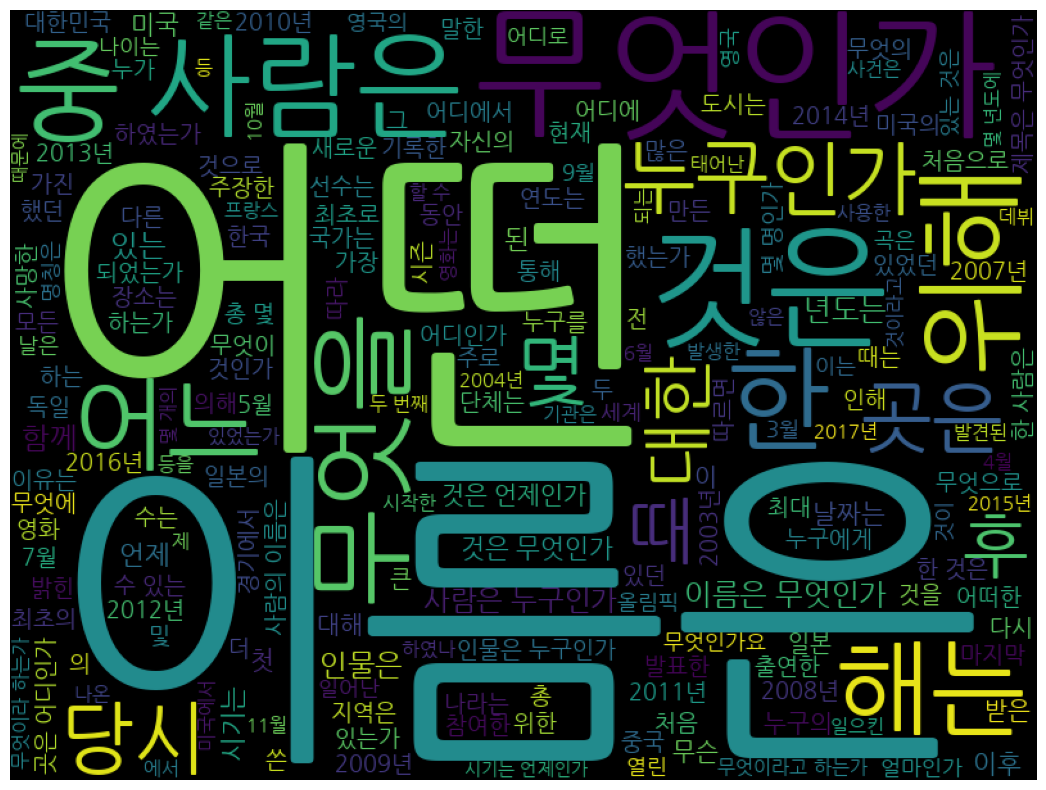

In [28]:
sampled_questions = sample(questions, 20000)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

**(2) 명사 토큰 기준**

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

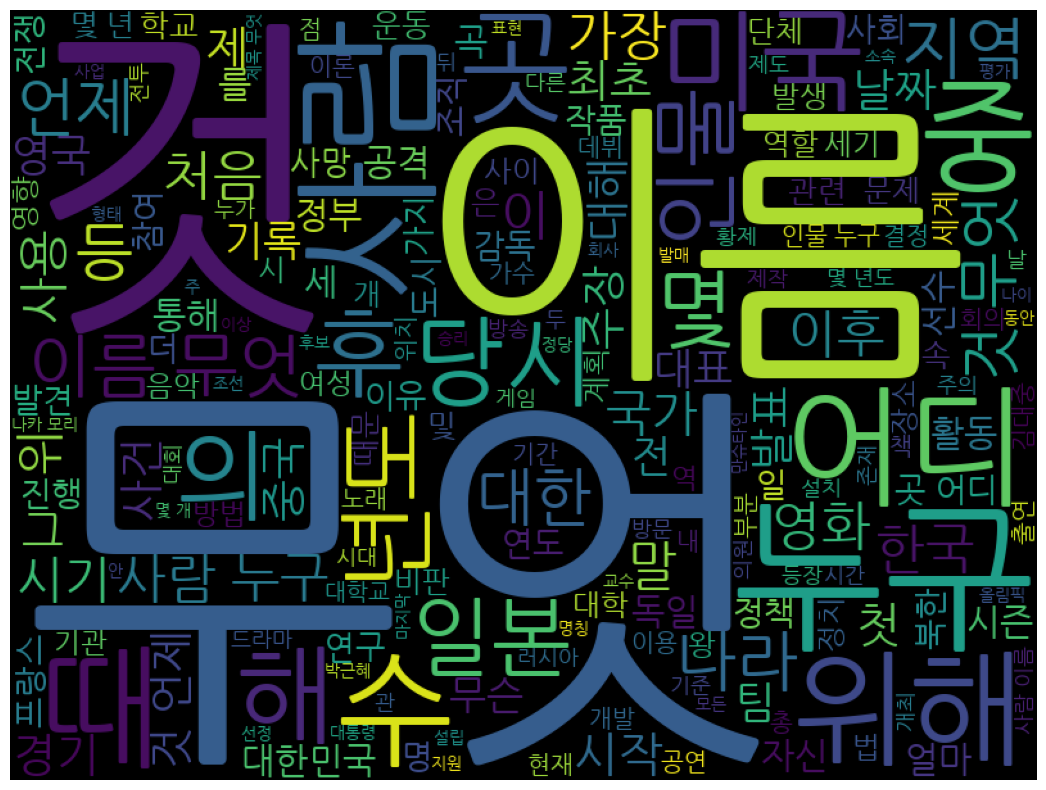

In [29]:
noun_extracted_qs = []
for q in sampled_questions:
    noun_extracted_qs += phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

## **2. KorQuAD 1.0 데이터 전처리**

In [30]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 384 # 지문 텍스트 평균 길이 약 312 정도
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

DATA_OUT_PATH = './data_out/KOR'

In [31]:
# 학습 시각화를 위한 시각화 함수
def plot_graphs(history, string, string_1, string_2) :
  plt.plot(history.history[string]) # 전체 손실값
  plt.plot(history.history[string_1]) # 시작점 손실값
  plt.plot(history.history[string_2]) # 끝점 손실값
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, string_1, string_2])
  plt.show()

In [32]:
# 사전 학습된 Bert 모델 로드 (GPU 환경이 아니면 작동X)
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)

# 저장 경로 지정
save_path = "saved_tokenizer/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# 토크나이저 저장
slow_tokenizer.save_pretrained(save_path)

# 저장된 vocab.txt로 fast tokenizer 불러오기
tokenizer = BertWordPieceTokenizer("saved_tokenizer/vocab.txt", lowercase=False)

In [33]:
# KorQuAD 데이터셋 다운로드
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)

eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

# 디렉토리 생성
save_dir = './saved_tokenizer'
os.makedirs(save_dir, exist_ok=True)

# config.json 다운로드 및 이름 변경
config_url = 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json'
config_path = wget.download(config_url, out=save_dir)
os.rename(config_path, os.path.join(save_dir, 'config.json'))

# tf_model.h5 다운로드 및 이름 변경
model_url = 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5'
model_path = wget.download(model_url, out=save_dir)
os.rename(model_path, os.path.join(save_dir, 'tf_model.h5'))

In [34]:
# raw data를 학습할때 모델에 입력할 수 있게 하는 클래스
# BERT 모델이 학습 가능한 형태로 전처리
class SquadExample :
  def __init__(self, question, context, start_char_idx, answer_text) :
    self.question = question # 질문
    self.context = context # 질문에 답이 존재하는 본문
    self.start_char_idx = start_char_idx # 본문에서의 시작위치
    self.answer_text = answer_text # 정답
    self.skip = False # 데이터를 사용할지 안할지
    # False -> 학습/평가 데이터로 사용
    # True -> 사용X(답이 본문에 존재X, end_char_idx가 본문 길이를 벗어난 위치인 경우)

  def preprocess(self) :
    context = self.context
    question = self.question
    answer_text = self.answer_text
    start_char_idx = self.start_char_idx

    # 불필요한 공백 제거 및 문자열로 강제 변환
    # 문자열 입력에 문제가 없도록 변경하기 위한 작업
    # str -> 문자열로 만들기
    # split() -> 스페이스 단위로 나누기
    # join -> 나눈 값들을 다시 스페이스 단위로 바꿔서
    # 해당 입력에 문제가 일어날 요소를 사전에 정리
    context = " ".join(str(context).split())
    question = " ".join(str(question).split())
    answer = " ".join(str(answer_text).split())

    # 정답이 본문을 벗어나면 유효하지 않다고 판단 → self.skip=True
    end_char_idx = start_char_idx + len(answer)
    if end_char_idx >= len(context) :
      self.skip = True
      return

    # Attention Mask 범위 설정
    # 정답 위치를 문자 단위 인덱스로 표시
    # context 길이만큼 리스트 만들고,
    # 정답이 위치한 인덱스는 1, 나머지는 0
    # 답이 존재하는 모든 인덱스 start_char_idx부터 end_char_ids까지 모두 1로 채움
    # 정답이 존재하지 않는 부분은 0
    is_char_in_ans = [0] * len(context)
    for idx in range(start_char_idx, end_char_idx) :
      is_char_in_ans[idx] = 1

    # context를 토큰화 -> BERT 입력 형식으로 변환
    tokenized_context = tokenizer.encode(context)

    ans_token_idx = []
    # 정답에 해당하는 토큰 인덱스 찾기(각 토큰이 정답에 걸쳐 있는지 확인)
    # tokenizer.encode() → offsets 제공 (각 토큰이 본문 어디에 위치하는지)
    for idx, (start, end) in enumerate(tokenized_context.offsets) :
      if sum(is_char_in_ans[start:end]) > 0 :
        # 정답이 걸쳐 있는 토큰만 골라서 ans_token_idx에 저장
        ans_token_idx.append(idx)

    if len(ans_token_idx) == 0 :
      self.skip = True
      return

    # 시작/끝 토큰 인덱스를 계산
    start_token_idx = ans_token_idx[0]
    end_token_idx = ans_token_idx[-1]

    # 질문 토큰화
    tokenized_question = tokenizer.encode(question)

    # 입력 : [CLS] context [SEP] question [SEP] 형식
    # token_type_ids: context → 0, question → 1
    input_ids = tokenized_context.ids + tokenized_question.ids[1:]
    token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
    attention_mask = [1] * len(input_ids)

    # 패딩 처리 및 예외 처리
    # 최대 길이만큼 패드 설정을 하고,
    # 예외 처리로 전체 길이가 0 이하면 Self.skip=0
    padding_length = MAX_LEN - len(input_ids)
    if padding_length > 0 :
      input_ids = input_ids + ([0] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)
      token_type_ids = token_type_ids + ([0] * padding_length)
    elif padding_length < 0 :
      self.skip = True
      return

    # 최종적으로 저장되는 데이터
    self.input_ids = input_ids
    self.token_type_ids = token_type_ids
    self.attention_mask = attention_mask
    self.start_token_idx = start_token_idx
    self.end_token_idx = end_token_idx
    self.context_token_to_char = tokenized_context.offsets

In [35]:
# json 데이터 구조에서 모델 입력에 필요한
# 질문, 본문, 정답을 가져오기 위한 함수
def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]  # 본문
            for qa in para["qas"]:
                question = qa["question"]  # 질문 문자열
                for answer in qa["answers"]:
                    answer_text = answer["text"] # 정답
                    start_char_idx = answer["answer_start"] # 정답의 위치
                    squad_eg = SquadExample(
                        question, context, start_char_idx, answer_text
                    )
                    squad_eg.preprocess()
                    squad_examples.append(squad_eg)
    return squad_examples

In [36]:
# BERT 모델이 학습 가능한 입력(x)과 출력(y) 형태로 변환
def create_inputs_targets(squad_examples):
    dataset_dict = { # 딕셔너리 생성
        "input_ids": [], # 토큰 ID 시퀀스 (문장 표현)
        "token_type_ids": [], # Segment 정보 (질문=1, 본문=0)
        "attention_mask": [], # 유효 토큰=1, 패딩=0
        "start_token_idx": [], # 정답 토큰 시작 위치
        "end_token_idx": [], # 정답 토큰 시작 끝 위치
    }

    # 유효한 샘플(skip=False)만 골라서 정보 수집
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))

    # 모델이 NumPy 배열로 입력 받기 때문에
    # 리스트 → 배열 변환
    for key in dataset_dict:
      dataset_dict[key] = np.array(dataset_dict[key])

    # 입력과 출력(target) 분리
    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [37]:
with open(train_path) as f :
  raw_train_data = json.load(f)

with open(eval_path) as f :
  raw_eval_data = json.load(f)

train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


## **3. KorQuAD 1.0 학습 및 테스트**

In [38]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path):
        super(TFBERTQuestionAnswering, self).__init__()
        # 사전학습된 BERT 모델 로드
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)

        # 각 토큰이 답의 시작/끝이 될 확률 점수(logits) 를 출력하는 Dense layer
        self.start_logit = tf.keras.layers.Dense(1, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(1, name="end_logit", use_bias=False)

        # Flatten: (batch, seq_len, 1) → (batch, seq_len)
        self.flatten = tf.keras.layers.Flatten()

        # Softmax: 시퀀스 상의 각 위치에 대해 확률 분포로 변환
        self.softmax = tf.keras.layers.Activation(keras.activations.softmax)

    # 순전파(forward)
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(
            input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
        )[0]  # BERT 출력 중 sequence output ([batch, seq_len, hidden_dim])만 사용

        # 시작/끝 토큰 점수 계산
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)

        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)

        # 확률 분포로 변환
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)

        return start_probs, end_probs

한국어 기게독해 모델을 생성하고 최전화 함수와 손실함수를 선언하자.

In [39]:
# 모델 초기화
korquad_model = TFBERTQuestionAnswering(
    model_name="bert-base-multilingual-cased",
    dir_path=save_dir
)

# 옵티마이저 및 손실 함수 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

모델의 결과를 정답과 비교하기 위해 후처리

In [40]:
# 정답 비교 시 정확도를 높이기 위해 문자열을 정규화(normalize)
# 비교 가능한 통일된 형식의 문자열로 변환
def normalized_answer(s):
    # 특수문자나 괄호류(", ', (, ), [, ], {, }, <, >)를 공백 " " 으로 바꾸는 함수
    # 괄호/기호 제거
    def remove_(text):
        text = re.sub('"', " ", text)
        text = re.sub("'", " ", text)
        text = re.sub('\(', " ", text)
        text = re.sub('\)', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text)
        text = re.sub('\[', " ", text)
        text = re.sub('\]', " ", text)
        text = re.sub('\{', " ", text)
        text = re.sub('\}', " ", text)
        text = re.sub('\(', " ", text)
        text = re.sub('\)', " ", text)
        return text

    # 여러 공백을 하나로 줄이고, 양쪽 공백 제거
    def white_space_fix(text):
        return ' '.join(text.split())

    # 모든 구두점 제거
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    # 소문자로 변환 → 대소문자 구분 없이 비교
    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [57]:
# 에포크가 끝날 때마다 정확 일치 정확도(Exact Match Accuracy)를 측정
# Exact Match : 부분점수 없이 예측값과 정답이 Character 단위로 완전히 같을 경우에만 1점 부여
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        super(ExactMatch, self).__init__()  # 부모 클래스 초기화
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None): # 각 epoch가 끝날 때 실행됨
        pred_start, pred_end = self.model.predict(self.x_eval) # 1. 모델 예측
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False] #  2. 정답 예제 불러오기

        for idx, (start, end) in enumerate(zip(pred_start, pred_end)): # 3. 예측 vs 정답 비교 루프
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start) # 예측 위치 계산
            end = np.argmax(end)
            if start >= len(offsets) or end >= len(offsets):
                continue
            pred_char_start = offsets[start][0] # 오프셋을 이용해 문자 위치로 변환
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end] # 예측 답 생성
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            # 정답과 비교 (normalized)
            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = [normalized_answer(a.text) for a in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1

        acc = count / len(self.y_eval[0]) # 정확도 출력
        print(f"\nepoch={epoch+1}, exact match={acc:.2f}")

In [56]:
# 수정 2
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        super(ExactMatch, self).__init__()
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0

        # 튜플 구조: (context, all_answers, offsets, skip)
        eval_examples_no_skip = [eg for eg in eval_squad_examples if not eg[3]]

        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            context, all_answers, offsets, _ = eval_examples_no_skip[idx]

            start = np.argmax(start)
            end = np.argmax(end)

            if start >= len(offsets) or end >= len(offsets):
                continue

            pred_char_start = offsets[start][0]
            pred_char_end = offsets[end][1] if end < len(offsets) else None
            pred_ans = context[pred_char_start:pred_char_end] if pred_char_end else context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = [normalized_answer(a) for a in all_answers]

            if normalized_pred_ans in normalized_true_ans:
                count += 1

        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch + 1}, exact match={acc:.2f}")


In [54]:
extract_match_callback = ExactMatch(x_eval, y_eval) # 각 에포크가 끝날 때 EM 점수 계산
korquad_model.compile(optimizer=optimizer, loss=[loss, loss]) # 모델에 옵티마이저와 손실 함수를 설정

In [55]:
# 모델 체크포인트 경로 설정
model_name = "tf2_bert_korquad"

# 'weights.h5'를 '.weights.h5'로 확장자를 수정
# Keras에서 save_weights_only=True일 때 .weights.h5 확장자가 필요
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# 디렉토리 생성 (없으면 생성)
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

# ModelCheckpoint로 콜백 설정
# 모델 학습 중 validation 성능이 최고일 때만 가중치를 저장
cp_callback = ModelCheckpoint(
    checkpoint_path,
    verbose=1, # 저장될 때 로그 출력
    save_best_only=True,  # 최고 성능 모델만 저장
    save_weights_only=True  # 가중치만 저장
)

./data_out/KOR/tf2_bert_korquad -- Folder already exists 



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# ModelCheckpoint : 모델을 학습하는 동안 일정한 간격으로 모델의 가중치를 저장하고,
# 최상의 성능을 보인 모델을 선택하는 기능을 제공

history = korquad_model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[extract_match_callback, cp_callback]
)

Epoch 1/3


In [ ]:
plot_graphs(history, 'loss', 'output1_loss', 'output2_loss')